In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import aux
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

- This notebook contains the code to reproduce the analysis and plotting for the first figure, using the companion dataset (which gives summary statistics for all plastic spiking networks simulated on the ISTA cluster)  
  
- Each section below can be run independently

### Plot rule shape (Fig1.B)

retrieved 2500/2500 simulations


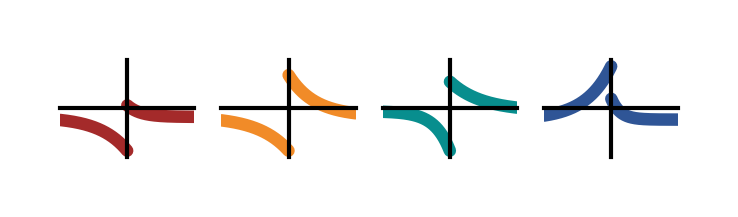

In [3]:
data = aux.load_and_merge("../data/data_sims/BND_IF_EEEIIEII_6pPol/",("2500_1s4hBreaks_17092024_metrics.npy",))

seed = 'f19bec85c2d4104a767b4b821891852d'
ind_seed = np.where(data['seed'] == seed)[0][0]
rule = data[ind_seed]['theta']
aux.plot_4_rules(rule, linewidth=1.5, axwidth=0.5,figsize=(1.33,0.21))

### Rule histograms (Fig1.C)

In [4]:
# load the data from saved run
data = aux.load_and_merge("../data/data_sims/BND_IF_EEEIIEII_6pPol/",("2850_1s4hBreaks_15082024_metrics.npy",))
# keep only the stable ones
inds_stable = aux.get_ind_stable(data)
d = data[inds_stable]

retrieved 2850/2850 simulations
2848 / 2850 rules fulfill the rate condition 99.9298245614035 %
2848 / 2850 rules fulfill the cv condition 99.9298245614035 %
2772 / 2850 rules fulfill the wf condition 97.26315789473684 %
2810 / 2850 rules fulfill the w_blow condition 98.59649122807016 %
2735 / 2850 rules fulfill all conditions 95.96491228070175 %


/Users/bcfx/Documents/Memory1000Rules/Code/Code_For_Paper/results/aux.py:256: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729646995093/work/aten/src/ATen/native/TensorShape.cpp:3687.)
  rules_tiled = torch.tile(rules, (n_timebins, 1, 1)).T # size [n_rules, n_timebins]
/Users/bcfx/Documents/Memory1000Rules/Code/Code_For_Paper/results/aux.py:721: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


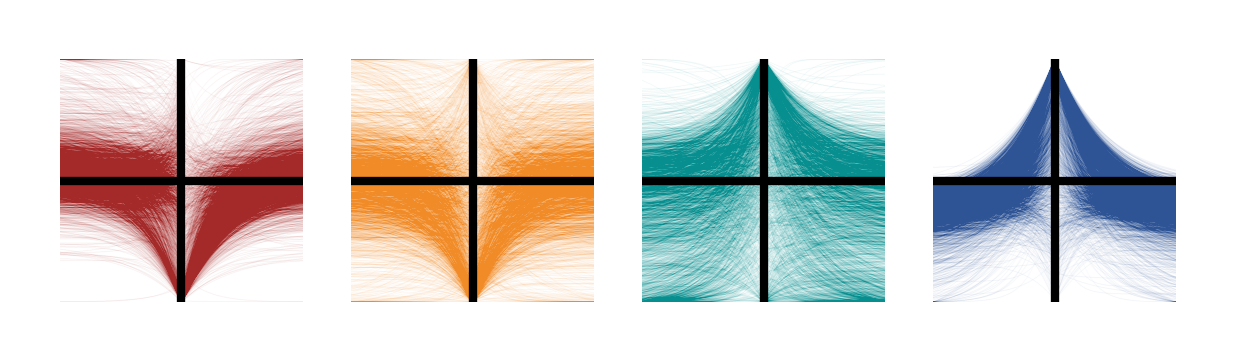

In [5]:
# compute the histogram of dw for each rule 
n_timebins = 1000; n_dwbins=1000
dws_ee, dws_ei, dws_ie, dws_ii, dws_hist_norm_ee, dws_hist_norm_ei, dws_hist_norm_ie, dws_hist_norm_ii = aux.get_shape_histogram(d['theta'][:,:-1], n_timebins=n_timebins, n_dwbins=n_dwbins)
# plot the histogram of dw for all rules in the dataset
aux.plot_4_rules_histogram(dws_hist_norm_ee,
                        dws_hist_norm_ei,
                        dws_hist_norm_ie,
                        dws_hist_norm_ii,
                        cmap_list = [aux.cmap_ee_white, aux.cmap_ei_white, aux.cmap_ie_white, aux.cmap_ii_white],
                        cap=5,
                        figsize=(2.4,0.6),
                        linewidth=1)

### Familiarity detection (Fig1.D)

In [6]:
# load data, 2500 rule quartets, 5 runs (trials) per rule on the familiarity task, all with break periods from 1s to 4h (10 break times)
save_dir = "../data/data_sims/BND_IF_EEEIIEII_6pPol/"
data1 = aux.load_and_merge(save_dir,("2500_1s4hBreaks_19082024_metrics.npy",))
data2 = aux.load_and_merge(save_dir,("2500_1s4hBreaks_20082024_metrics.npy",))
data3 = aux.load_and_merge(save_dir,("2500_1s4hBreaks_17092024_metrics.npy",))
data4 = aux.load_and_merge(save_dir,("2500_1s4hBreaks_22092024_metrics.npy",))
data5 = aux.load_and_merge(save_dir,("2500_1s4hBreaks_24092024_metrics.npy",))
dataset_list = [data1, data2, data3, data4, data5]
n_rules = len(data1)

# compute delta r mem and delta sigma r mem for each rule, each break time and each dataset
dr = np.array([2*(d['r_nov'] - d['r_fam']) / (d['r_nov'] + d['r_fam']+0.01) for d in dataset_list])
mdr = np.nan_to_num(np.mean(dr, axis=0), nan=0.0) # mean dr across runs
# same for delta sigma r mem
dsr = np.array([2*(d['std_nov'] - d['std_fam']) / (d['std_nov'] + d['std_fam']+0.01) for d in dataset_list])

retrieved 2500/2500 simulations
retrieved 2500/2500 simulations
retrieved 2500/2500 simulations
retrieved 2500/2500 simulations
retrieved 2500/2500 simulations


In [7]:
# Perform a Student t-test on r_fam samples vs r_nov samples for each rule: do the 2 distributions have the same mean or not?
n_ts = 10
proportion = np.zeros(n_ts)
pvalues = np.zeros((n_rules, n_ts))
for t in range(n_ts):
    for ind in range(n_rules):
        r_nov_samples = np.array([d['r_nov'][ind,t] for d in dataset_list])
        r_fam_samples = np.array([d['r_fam'][ind,t] for d in dataset_list])
        pvalues[ind, t] = ttest_ind(r_nov_samples, r_fam_samples).pvalue
    proportion[t] = np.sum(pvalues[:,t]<0.05)/len(pvalues[:,t])
sign_resp = pvalues < 0.05

# Find time of last significant response
t_last_sign = np.zeros((n_rules))-1
for ind in range(n_rules):
    if len(np.where(sign_resp[ind,:]==True)[0]) > 0:
        t_last_sign[ind] = np.where(sign_resp[ind,:]==True)[0][-1]

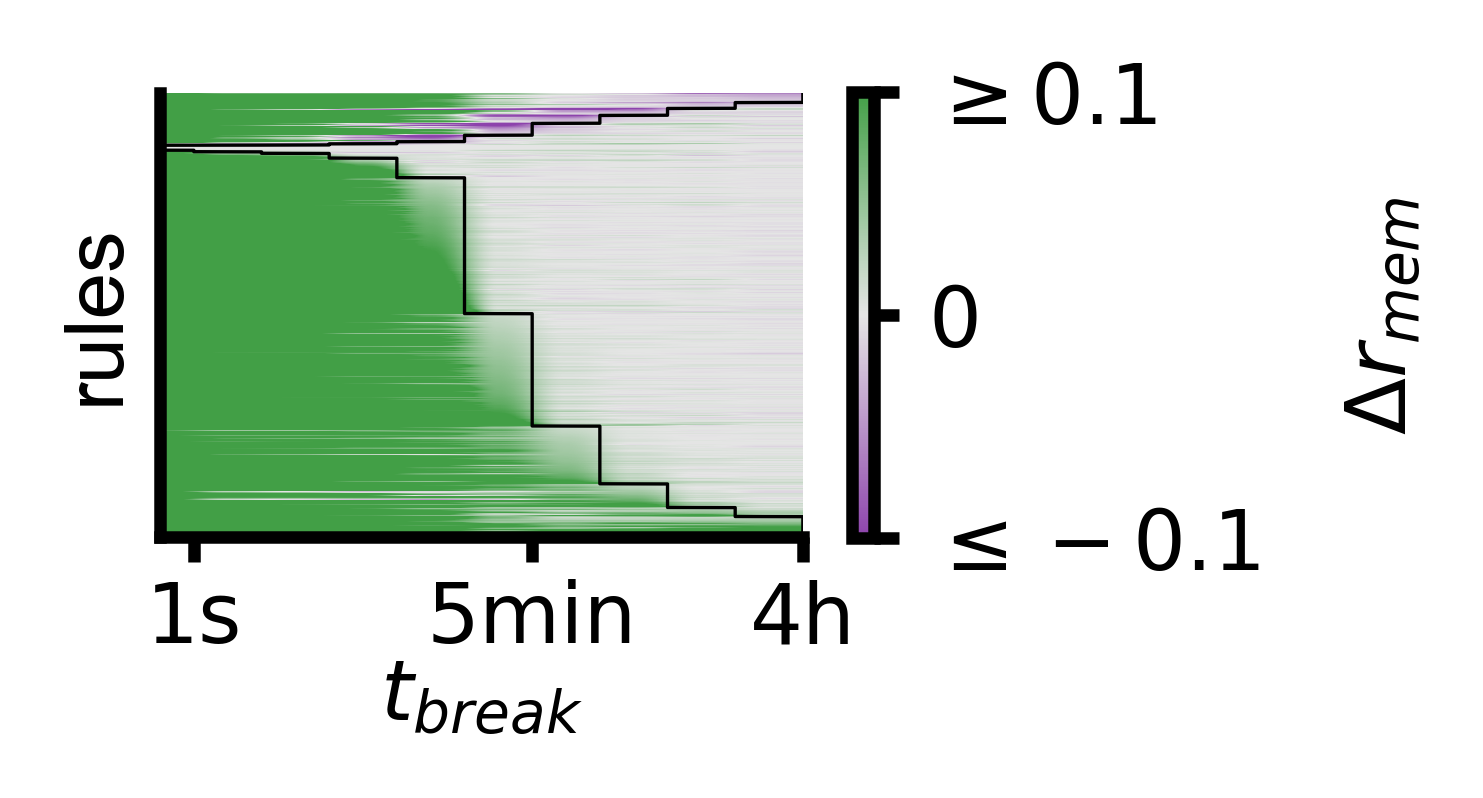

In [8]:
# Reorder the rules according to time of last singificant response
# major ordering 1: familiar or novel preferering
# major ordering 2: which t do you stop being significant at
# minor ordering: ascending mdr
mdr_reordered = np.zeros( (n_rules, n_ts) )
t_last_sign_reordered = np.zeros(n_rules)-1
count_left = 0
count_right = n_rules

for last_t in range(n_ts-1, -1, -1):
    ind_ts = np.where(t_last_sign == last_t)[0]
    ind_ts_fam = np.where(mdr[:,last_t][ind_ts] < 0)[0]
    ind_ts_nov = np.where(mdr[:,last_t][ind_ts] >= 0)[0]
    ordered_inds_fam = np.argsort(mdr[:,last_t][ind_ts][ind_ts_fam])
    n_inds_fam_to_add = len(ordered_inds_fam)
    ordered_inds_nov = np.argsort(mdr[:,last_t][ind_ts][ind_ts_nov])
    n_inds_nov_to_add = len(ordered_inds_nov)
    mdr_reordered[count_left:(count_left+n_inds_fam_to_add)] = mdr[ind_ts][ind_ts_fam][ordered_inds_fam]
    mdr_reordered[(count_right-n_inds_nov_to_add):count_right] = mdr[ind_ts][ind_ts_nov][ordered_inds_nov]
    t_last_sign_reordered[count_left:(count_left+n_inds_fam_to_add)] = last_t
    t_last_sign_reordered[(count_right-n_inds_nov_to_add):count_right] = last_t
    count_left += n_inds_fam_to_add
    count_right -= n_inds_nov_to_add

# defining the time points in seconds corresponding to the time breaks
breaks = [1, 9, 10, 40, 60, 180, 300, 600, 2400, 10800]
ts = [ np.sum(breaks[:i]) for i in range(1,len(breaks)+1) ]

# plotting the heatmap of the response strength ordered by the last time point where the sign of the response changes, with familiar-preferring rules on the left and novel-preferring rules on the right, and with a colorbar indicating the strength of the response
aux.plot_metric_tbreaks_all_rules(mdr_reordered,
    t_last_sign_reordered,
    figsize=(1.75,1.15),
    dpi=600,
    cmap = aux.cmap_famdet,
    x_lim = [0,9.5],
    x_ticks = [0,5,9],
    x_ticklabels = ["1s","5min","4h"],
    x_label=r'$t_{break}$',
    y_lim=None,
    y_ticks=None,
    y_ticklabels=None,
    y_label="rules",
    vmin=-0.1,
    vmax=0.1,
    cbarticks=[-0.1,0,0.1],
    cbarticklabels=[r'$\leq-0.1$',r'$0$',r'$\geq 0.1$'],
    cbarhandlepad=10,
    axwidth=1.5,
    linewidth=1.5,
    xticks_pad=2,
    yticks_pad=0,
    labelpad_xlabel=0,
    rotation=0,
    labelpad_ylabel=3,
    color_ylabel='black',
    heatmap_label=r'$\Delta r_{mem}$',
    linewidth_sign=0.4)

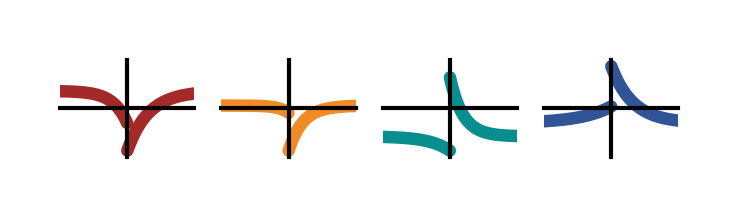

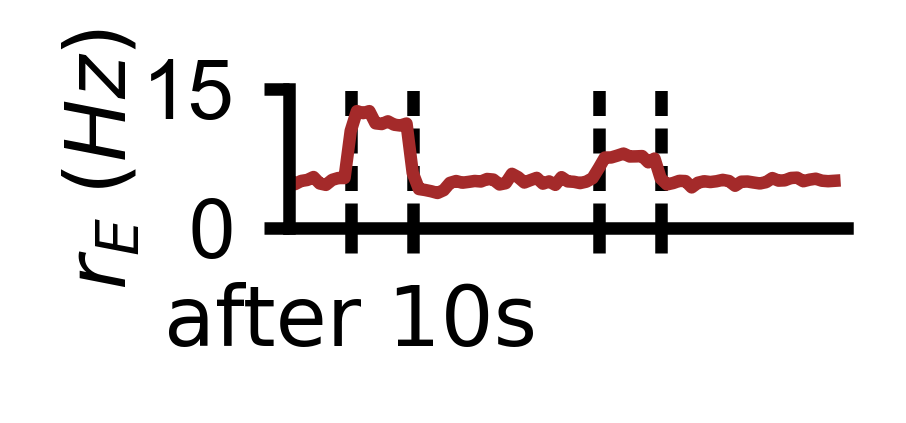

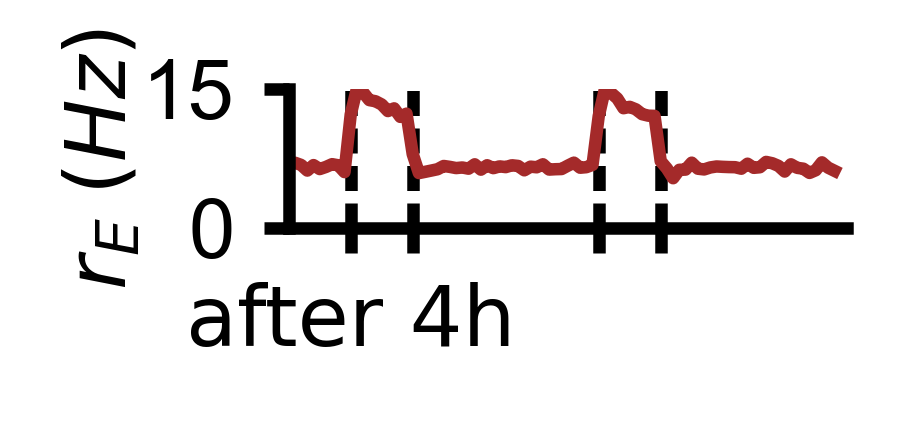

In [9]:
# plot a specific rule
seed = 'f68939fc0aac0721b2963e0f3452ded5'

ind_seed = np.where(data1['seed'] == seed)[0][0]
rule = data1[ind_seed]['theta']
aux.plot_4_rules(rule, linewidth=1.5, axwidth=0.5,figsize=(1.33,0.21))

aux.plot_pop_rate(rs = data1[ind_seed]["prate"][1,:],
                           ts = [i for i in range(data1[ind_seed]["prate"].shape[1])],
                           t_lim = [0,90],
                           y_label = r'$r_E\; (Hz)$',
                           r_lim = [0,15],
                           color = aux.color_ee,
                           x_ticks=[10, 20, 50, 60],
                           x_milestones=[10, 20, 50, 60],
                           x_ticklabels=['after 10s', '', '', ''],
                           x_label = None,
                           fontsize = 10,
                           linewidth = 1.5,
                           axwidth = 1.5,
                           save_path = None,
                           figsize = (1.2,0.3),
                           rotation=0,
                           dpi=600,
                           target = None); plt.show()

ax_pop_rate = aux.plot_pop_rate(rs = data1[ind_seed]["prate"][9,:],
                           ts = [i for i in range(data1[ind_seed]["prate"].shape[1])],
                           t_lim = [0,90],
                           y_label = r'$r_E\; (Hz)$',
                           r_lim = [0,15],
                           color = aux.color_ee,
                           x_ticks=[10, 20, 50, 60],
                           x_milestones=[10, 20, 50, 60],
                           x_ticklabels=['after 4h', '', '', ''],
                           x_label = None,
                           fontsize = 10,
                           linewidth = 1.5,
                           axwidth = 1.5,
                           save_path = None,
                           figsize = (1.2,0.3),
                           rotation=0,
                           dpi=600,
                           target = None); plt.show()

#### Bonus: control that static networks don't respond to this task

In [10]:
dataset_static = aux.load_and_merge(save_dir,("100static_1s4hBreaks_12082024_metrics.npy",))
n_trials_static = len(dataset_static)
dr_static = 2*(dataset_static['r_nov'] - dataset_static['r_fam']) / (dataset_static['r_nov'] + dataset_static['r_fam']+0.01)
dsr_static = 2*(dataset_static['std_nov'] - dataset_static['std_fam']) / (dataset_static['std_nov'] + dataset_static['std_fam']+0.01)

#check that the static net are not signigicant
n_ts = 10
pvalues =np.zeros(n_ts)
for t in range(n_ts):
    pvalues[t] = ttest_ind(dataset_static['r_nov'][:,t],
                            dataset_static['r_fam'][:,t]).pvalue
print(pvalues)

retrieved 100/100 simulations
[0.57553429 0.63526528 0.46446465 0.99658831 0.73833846 0.7672866
 0.9775736  0.72823462 0.45902325 0.64948814]


### Transient dynamics (Fig.E)

In [11]:
# load data, 2500 rule quartets, 5 runs (trials) per rule on the familiarity task, all with break periods from 1s to 4h (10 break times)
# same sims as the familiarity detection task, different analysis, we care about transient responses here
save_dir = "../data/data_sims/BND_IF_EEEIIEII_6pPol/"
data1 = aux.load_and_merge(save_dir,("2500_1s4hBreaks_19082024_metrics.npy",))
data2 = aux.load_and_merge(save_dir,("2500_1s4hBreaks_20082024_metrics.npy",))
data3 = aux.load_and_merge(save_dir,("2500_1s4hBreaks_17092024_metrics.npy",))
data4 = aux.load_and_merge(save_dir,("2500_1s4hBreaks_22092024_metrics.npy",))
data5 = aux.load_and_merge(save_dir,("2500_1s4hBreaks_24092024_metrics.npy",))
dataset_list = [data1, data2, data3, data4, data5]
n_rules = len(data1)

retrieved 2500/2500 simulations
retrieved 2500/2500 simulations
retrieved 2500/2500 simulations
retrieved 2500/2500 simulations
retrieved 2500/2500 simulations


In [12]:
# compute metrics of ON response to novel, OFF max response to novel, OFF min response to novel, ON response to familiar, OFF max response to familiar, OFF min response to familiar, averaged across runs and across rules
on_nov = np.nanmean( [np.max(d['prate'][:,:,10:20], axis=2)/(np.nanmean(d['prate'][:,:,10:20], axis=2)+0.01) for d in dataset_list], axis=0 )
offmax_nov = np.nanmean( [np.max(d['prate'][:,:,22:32], axis=2)/(np.nanmean(d['prate'][:,:,22:32], axis=2)+0.01) for d in dataset_list], axis=0 )
offmin_nov = np.nanmean( [np.min(d['prate'][:,:,22:32], axis=2)/(np.nanmean(d['prate'][:,:,22:32], axis=2)+0.01) for d in dataset_list], axis=0 )
on_fam = np.nanmean( [np.max(d['prate'][:,:,50:60], axis=2)/(np.nanmean(d['prate'][:,:,50:60], axis=2)+0.01) for d in dataset_list], axis=0 )
offmax_fam = np.nanmean( [np.max(d['prate'][:,:,62:72], axis=2)/(np.nanmean(d['prate'][:,:,62:72], axis=2)+0.01) for d in dataset_list], axis=0 )
offmin_fam = np.nanmean( [np.min(d['prate'][:,:,62:72], axis=2)/(np.nanmean(d['prate'][:,:,62:72], axis=2)+0.01) for d in dataset_list], axis=0 )

DeltaON = np.nan_to_num(2*(on_nov-on_fam)/(on_nov+on_fam), nan=0.0)
DeltaOFFmax = 2*(offmax_nov-offmax_fam)/(offmax_nov+offmax_fam)
DeltaOFFmin = 2*(offmin_nov-offmin_fam)/(offmin_nov+offmin_fam)

/var/folders/fg/6y_rzvdn0_s9tr1lxxw5r9p40000gn/T/ipykernel_23262/1767711450.py:2: RuntimeWarning: Mean of empty slice
  on_nov = np.nanmean( [np.max(d['prate'][:,:,10:20], axis=2)/(np.nanmean(d['prate'][:,:,10:20], axis=2)+0.01) for d in dataset_list], axis=0 )
/var/folders/fg/6y_rzvdn0_s9tr1lxxw5r9p40000gn/T/ipykernel_23262/1767711450.py:3: RuntimeWarning: Mean of empty slice
  offmax_nov = np.nanmean( [np.max(d['prate'][:,:,22:32], axis=2)/(np.nanmean(d['prate'][:,:,22:32], axis=2)+0.01) for d in dataset_list], axis=0 )
/var/folders/fg/6y_rzvdn0_s9tr1lxxw5r9p40000gn/T/ipykernel_23262/1767711450.py:4: RuntimeWarning: Mean of empty slice
  offmin_nov = np.nanmean( [np.min(d['prate'][:,:,22:32], axis=2)/(np.nanmean(d['prate'][:,:,22:32], axis=2)+0.01) for d in dataset_list], axis=0 )
/var/folders/fg/6y_rzvdn0_s9tr1lxxw5r9p40000gn/T/ipykernel_23262/1767711450.py:5: RuntimeWarning: Mean of empty slice
  on_fam = np.nanmean( [np.max(d['prate'][:,:,50:60], axis=2)/(np.nanmean(d['prate'][:,:

In [13]:
# Perform a Student t-test on On responses for novel stim vs On responses to familiar stimuli
n_ts = 10
proportion = np.zeros(n_ts)
pvalues = np.zeros((n_rules, n_ts))
for t in range(n_ts):
    for ind in range(n_rules):
        on_nov_samples = np.array([np.max(d['prate'][ind,t,10:20], axis=0)/(np.nanmean(d['prate'][ind,t,10:20], axis=0)+0.01) for d in dataset_list])
        on_fam_samples = np.array([np.max(d['prate'][ind,t,50:60], axis=0)/(np.nanmean(d['prate'][ind,t,50:60], axis=0)+0.01) for d in dataset_list])
        pvalues[ind, t] = ttest_ind(on_nov_samples, on_fam_samples).pvalue
    proportion[t] = np.sum(pvalues[:,t]<0.05)/len(pvalues[:,t])
sign_resp = pvalues < 0.05

t_last_sign = np.zeros((n_rules))-1
for ind in range(n_rules):
    if len(np.where(sign_resp[ind,:]==True)[0]) > 0:
        t_last_sign[ind] = np.where(sign_resp[ind,:]==True)[0][-1]

# major ordering 1: familiar or novel preferering
# major ordering 2: which t do you stop being significant at
# minor ordering: ascending mdr
# ordering = np.array([i for i in range(n_rules)])
DeltaON_reordered = np.zeros( (n_rules, n_ts) )
t_last_sign_reordered = np.zeros(n_rules)-1
count_left = 0
count_right = n_rules

for last_t in range(n_ts-1, -1, -1):
    ind_ts = np.where(t_last_sign == last_t)[0]
    ind_ts_fam = np.where(DeltaON[:,last_t][ind_ts] < 0)[0]
    ind_ts_nov = np.where(DeltaON[:,last_t][ind_ts] >= 0)[0]
    ordered_inds_fam = np.argsort(DeltaON[:,last_t][ind_ts][ind_ts_fam])
    n_inds_fam_to_add = len(ordered_inds_fam)
    ordered_inds_nov = np.argsort(DeltaON[:,last_t][ind_ts][ind_ts_nov])
    n_inds_nov_to_add = len(ordered_inds_nov)
    DeltaON_reordered[count_left:(count_left+n_inds_fam_to_add)] = DeltaON[ind_ts][ind_ts_fam][ordered_inds_fam]
    DeltaON_reordered[(count_right-n_inds_nov_to_add):count_right] = DeltaON[ind_ts][ind_ts_nov][ordered_inds_nov]
    t_last_sign_reordered[count_left:(count_left+n_inds_fam_to_add)] = last_t
    t_last_sign_reordered[(count_right-n_inds_nov_to_add):count_right] = last_t
    count_left += n_inds_fam_to_add
    count_right -= n_inds_nov_to_add

/var/folders/fg/6y_rzvdn0_s9tr1lxxw5r9p40000gn/T/ipykernel_23262/1935662676.py:7: RuntimeWarning: Mean of empty slice
  on_nov_samples = np.array([np.max(d['prate'][ind,t,10:20], axis=0)/(np.nanmean(d['prate'][ind,t,10:20], axis=0)+0.01) for d in dataset_list])
/var/folders/fg/6y_rzvdn0_s9tr1lxxw5r9p40000gn/T/ipykernel_23262/1935662676.py:8: RuntimeWarning: Mean of empty slice
  on_fam_samples = np.array([np.max(d['prate'][ind,t,50:60], axis=0)/(np.nanmean(d['prate'][ind,t,50:60], axis=0)+0.01) for d in dataset_list])


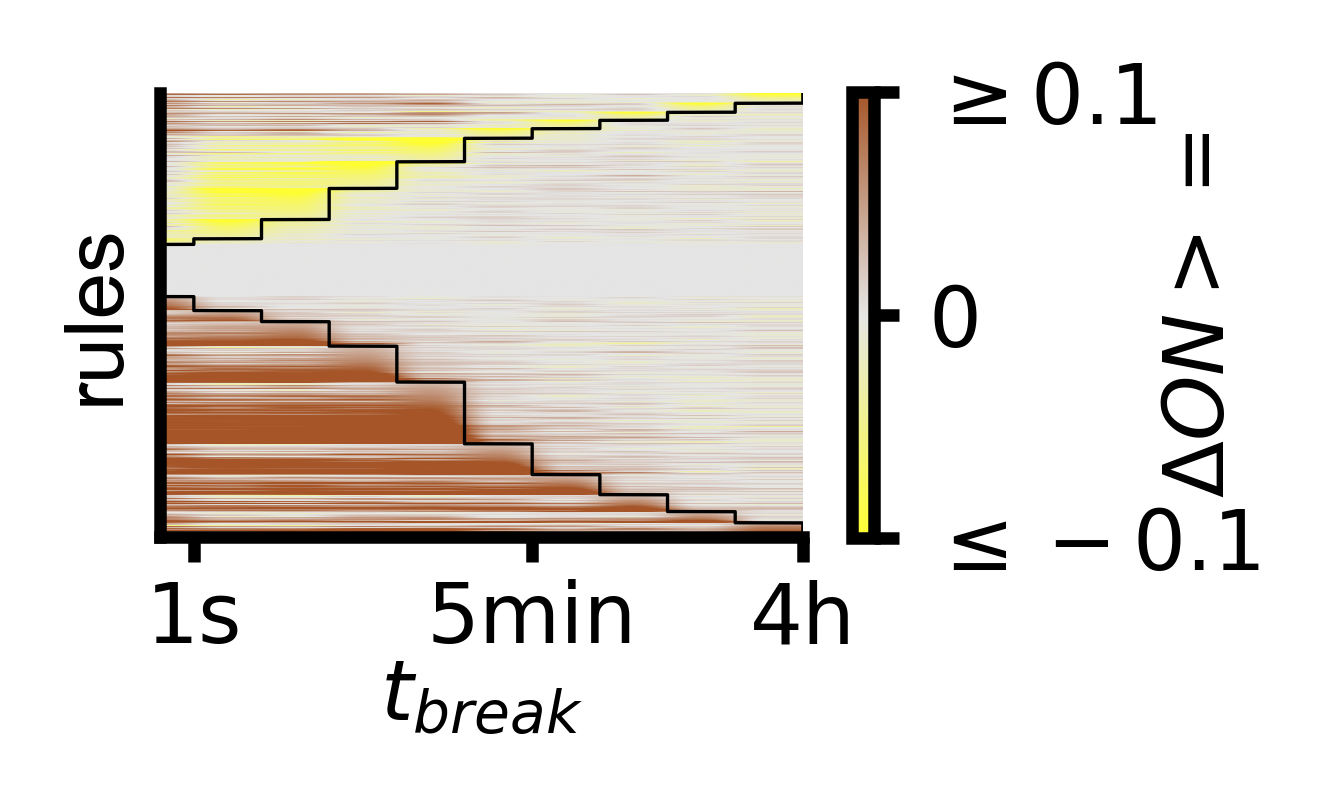

In [14]:
breaks = [1, 9, 10, 40, 60, 180, 300, 600, 2400, 10800]
ts = [ np.sum(breaks[:i]) for i in range(1,len(breaks)+1) ]

aux.plot_metric_tbreaks_all_rules(DeltaON_reordered,
    t_last_sign_reordered,
    figsize=(1.75,1.15),
    dpi=600,
    cmap = aux.cmp_transdyn,
    x_lim = [0,9.5],
    x_ticks = [0,5,9],
    x_ticklabels = ["1s","5min","4h"],
    x_label=r'$t_{break}$',
    y_lim=None,
    y_ticks=None,
    y_ticklabels=None,
    y_label="rules",
    vmin=-0.1,
    vmax=0.1,
    cbarticks=[-0.1,0,0.1],
    cbarticklabels=[r'$\leq-0.1$',r'$0$',r'$\geq 0.1$'],
    cbarhandlepad=-12,
    axwidth=1.5,
    linewidth=1.5,
    xticks_pad=2,
    yticks_pad=0,
    labelpad_xlabel=0,
    rotation=0,
    labelpad_ylabel=3,
    color_ylabel='black',
    heatmap_label=r'$\Delta ON > =$',
    linewidth_sign=0.4)

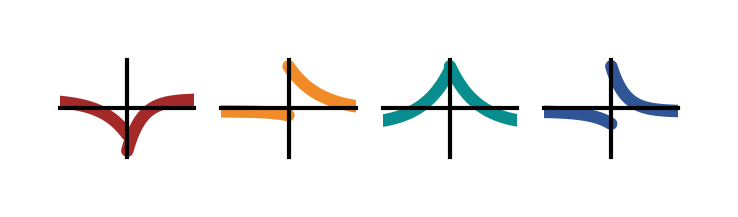

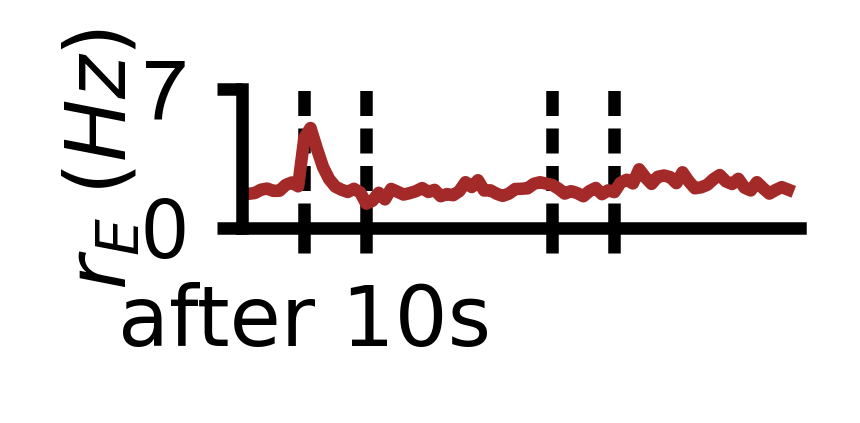

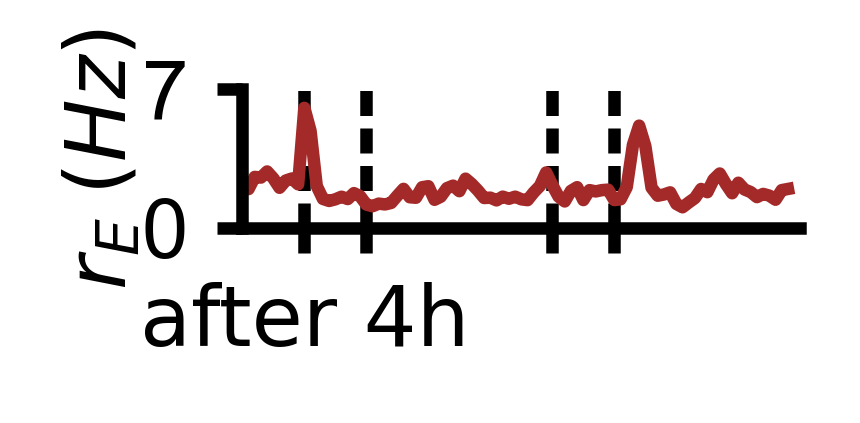

In [15]:
# plot a specific rule
seed = '43ac91b4c897f23f7283a3dc21af5644' #rule that keeps preferring novel, ON response to nov, aquired off response to fam

ind_seed = np.where(data1['seed'] == seed)[0][0]
rule = data1[ind_seed]['theta']
aux.plot_4_rules(rule, linewidth=1.5, axwidth=0.5,figsize=(1.33,0.21))

aux.plot_pop_rate(rs = data1[ind_seed]["prate"][1,:],
                           ts = [i for i in range(data1[ind_seed]["prate"].shape[1])],
                           t_lim = [0,90],
                           y_label = r'$r_E\; (Hz)$',
                           r_lim = [0,7],
                           color = aux.color_ee,
                           x_ticks=[10, 20, 50, 60],
                           x_milestones=[10, 20, 50, 60],
                           x_ticklabels=['after 10s', '', '', ''],
                           x_label = None,
                           fontsize = 10,
                           linewidth = 1.5,
                           axwidth = 1.5,
                           save_path = None,
                           figsize = (1.2,0.3),
                           rotation=0,
                           dpi=600,
                           target = None); plt.show()

ax_pop_rate = aux.plot_pop_rate(rs = data1[ind_seed]["prate"][9,:],
                           ts = [i for i in range(data1[ind_seed]["prate"].shape[1])],
                           t_lim = [0,90],
                           y_label = r'$r_E\; (Hz)$',
                           r_lim = [0,7],
                           color = aux.color_ee,
                           x_ticks=[10, 20, 50, 60],
                           x_milestones=[10, 20, 50, 60],
                           x_ticklabels=['after 4h', '', '', ''],
                           x_label = None,
                           fontsize = 10,
                           linewidth = 1.5,
                           axwidth = 1.5,
                           save_path = None,
                           figsize = (1.2,0.3),
                           rotation=0,
                           dpi=600,
                           target = None); plt.show()

### Successor representation task (sequence learning, Fig1.F)

In [16]:
# load the simulated data: 2500 rule quartets, 10 break times, 3 runs (trials)
seq1 = aux.load_and_merge("../data/data_sims/seq_IF_EEEIIEII_6pPol/",("2500_seq_1s4hBreaks_07112024_metrics.npy",))
seq2 = aux.load_and_merge("../data/data_sims/seq_IF_EEEIIEII_6pPol/",("2500_seq_1s4hBreaks_10112024_metrics.npy",))
seq3 = aux.load_and_merge("../data/data_sims/seq_IF_EEEIIEII_6pPol/",("2500_seq_1s4hBreaks_16112024_metrics.npy",))
seq_list = [seq1, seq2, seq3]

break_durations = [1, 9,  10, 40, 60,  180, 300, 600,  2400, 10800]
total_breaks = [np.sum(break_durations[:i+1]) for i in range(len(break_durations))]
n_tests = len(break_durations)

retrieved 2500/2500 simulations
retrieved 2500/2500 simulations
retrieved 2500/2500 simulations


In [17]:
# compute metrics on the sequence task
n_fam = 5 #number of familiar stimuli
n_nov = 2 #number of novel stimuli
n_tot = 7 #total number of stimuli, including novel ones
n_rules = seq1['eng_rate'].shape[0]
n_tests = seq1['eng_rate'].shape[1]
n_engs = seq1['eng_rate'].shape[2]
n_bins = seq1['eng_rate'].shape[3]
ontime_test = 2 #in number of bins. usually bin is 0.1s
offtime_test = 28 #in number of bins. usually bin is 0.1s
test_starts = 10 #in number of bins, how long do we record pretest (usually 1s)

t_breaks = break_durations
# assume that the ordering of pretraining and testing of stimuli is the same: n1 n2 f1 f2 f3 f4 f5
succ = np.array([aux.compute_succ(eng_rate=seq['eng_rate'], n_tot=n_tot, n_bins=n_bins, 
                                  test_starts=test_starts, ontime_test=ontime_test,
                                  offtime_test=offtime_test,n_rules=n_rules, n_tests=n_tests,
                                  n_fam=n_fam, n_engs=n_engs, method='both',
                                  raw_r_rest=seq['non_eng_rate'], raw_r_pop=seq['prate']) for seq in seq_list])
succ = np.mean(succ, axis=4)

In [18]:
# ttest on the response of engram of the next stimulus in the sequence compared to a novel stimulus
fams_novs_ttest = [aux.get_rsucc_rnov(eng_rate=seq['eng_rate'], n_tot=n_tot, n_bins=n_bins, test_starts=test_starts, ontime_test=ontime_test, offtime_test=offtime_test,
                 n_rules=n_rules, n_tests=n_tests, n_fam=n_fam, n_engs=n_engs) for seq in seq_list]
r_non_eng_ttest = [aux.get_r_rest(n_tot, n_bins, test_starts, ontime_test, offtime_test,
                                  seq['non_eng_rate'], n_rules, n_engs, n_tests) for seq in seq_list]
r_prate_ttest = [aux.get_r_rest(n_tot, n_bins, test_starts, ontime_test, offtime_test,
                                  seq['prate'], n_rules, n_engs, n_tests) for seq in seq_list]

metric_num = 3 #3 means next stimulus activity
method = "both"
n_ts = 10
proportion = np.zeros(n_ts)
pvalues =np.zeros((n_rules, n_ts))
for test_num in range(n_ts):
    for rule_num in range(n_rules):
        fam_samples = np.array( [ fams_novs_ttest[i][0][rule_num,test_num,metric_num,:] for i in range(len(seq_list)) ] ).flatten()
        if method == "both": ### averaging nov1 and nov2
            nov_samples = np.array( [ fams_novs_ttest[i][1][rule_num,test_num,:,:] for i in range(len(seq_list)) ] ).flatten()
        else:
            print("method unknown")   
        pvalues[rule_num, test_num] = ttest_ind(nov_samples, fam_samples).pvalue
    proportion[test_num] = np.sum(pvalues[:,test_num]<0.05)/len(pvalues[:,test_num])

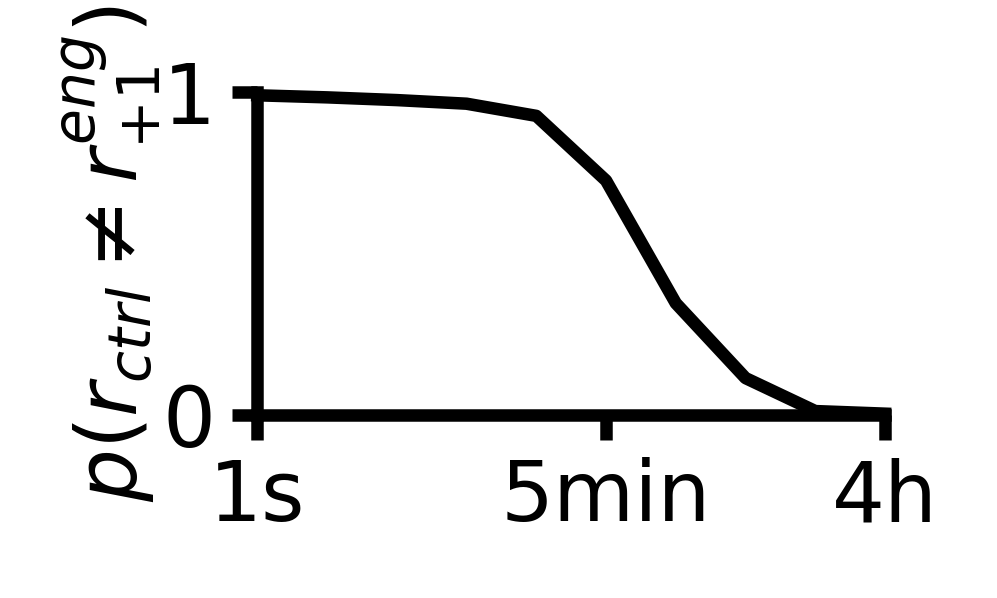

In [19]:
aux.plot_fraction_significant_rules(proportion,
                                    x_lim=[0,9],
                                    x_ticks=[0,5,9],
                                    x_ticklabels=['1s', '5min', '4h'],
                                    y_lim = [0,1],
                                    y_ticks=[0,1],
                                    x_label='',
                                    y_label=r'$p(r_{ctrl} \neq r_{+1}^{eng})$',
                                    xticks_pad=2,
                                    yticks_pad=2,
                                    labelpad_ylabel = 0,
                                    figsize=(1.35,0.7))

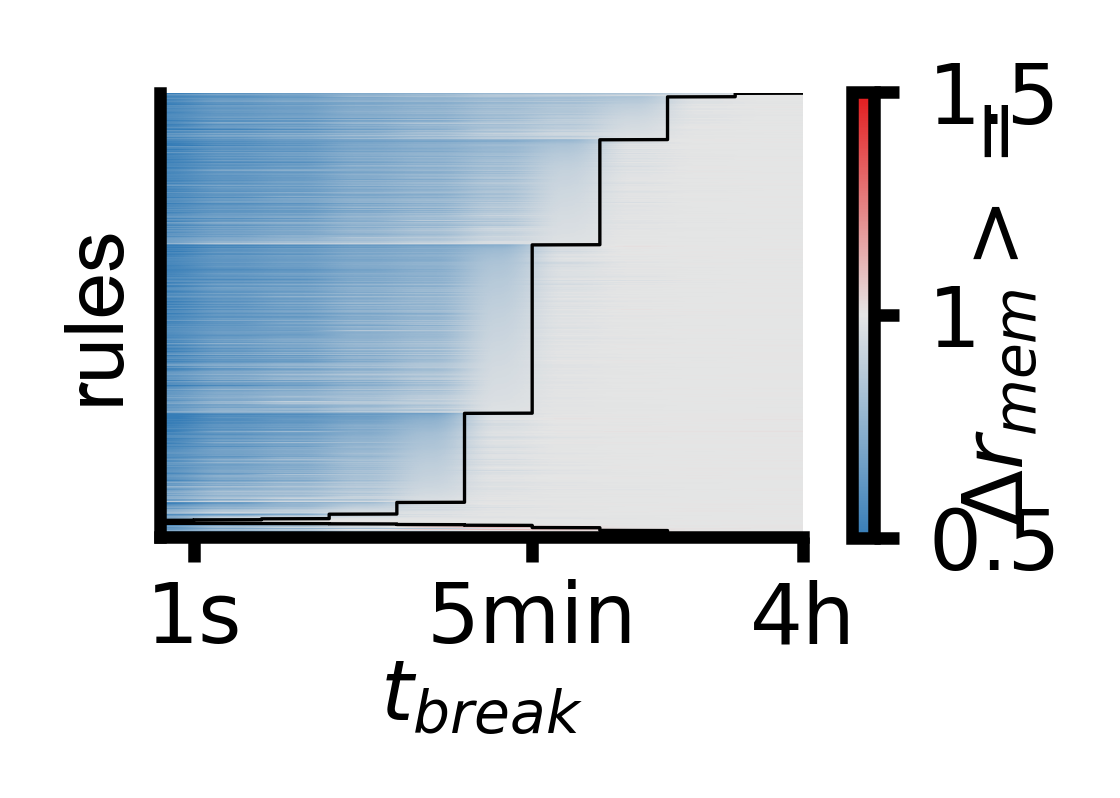

In [20]:
# looking at the last time point where the p-value is significant < 0.05
# we do not compensate for multiple test
sign_resp = pvalues < 0.05
t_last_sign = np.zeros((n_rules))-1
for ind in range(n_rules):
    if len(np.where(sign_resp[ind,:]==True)[0]) > 0:
        t_last_sign[ind] = np.where(sign_resp[ind,:]==True)[0][-1]

# major ordering 1: familiar or novel preferering
# major ordering 2: which t do you stop being significant at
# minor ordering: ascending mdr
# ordering = np.array([i for i in range(n_rules)])
metric_num = 3 # m+1
av_succ = np.mean(succ, axis=0)[:,:,metric_num]
av_succ_reordered = np.zeros( (n_rules, n_ts) ) + 1
t_last_sign_reordered = np.zeros(n_rules)-1
count_left = 0
count_right = n_rules

for last_t in range(n_ts-1, -1, -1):
    ind_ts = np.where(t_last_sign == last_t)[0]
    ind_ts_fam = np.where(av_succ[:,last_t][ind_ts] < 1)[0]
    ind_ts_nov = np.where(av_succ[:,last_t][ind_ts] >= 1)[0]
    ordered_inds_fam = np.argsort(av_succ[:,last_t][ind_ts][ind_ts_fam])
    n_inds_fam_to_add = len(ordered_inds_fam)
    ordered_inds_nov = np.argsort(av_succ[:,last_t][ind_ts][ind_ts_nov])
    n_inds_nov_to_add = len(ordered_inds_nov)
    av_succ_reordered[count_left:(count_left+n_inds_fam_to_add)] = av_succ[ind_ts][ind_ts_fam][ordered_inds_fam]
    av_succ_reordered[(count_right-n_inds_nov_to_add):count_right] = av_succ[ind_ts][ind_ts_nov][ordered_inds_nov]
    t_last_sign_reordered[count_left:(count_left+n_inds_fam_to_add)] = last_t
    t_last_sign_reordered[(count_right-n_inds_nov_to_add):count_right] = last_t
    count_left += n_inds_fam_to_add
    count_right -= n_inds_nov_to_add

# plotting the heatmap of the response strength ordered by the last time point where the response stops being significant
breaks = [1, 9, 10, 40, 60, 180, 300, 600, 2400, 10800]
ts = [ np.sum(breaks[:i]) for i in range(1,len(breaks)+1) ]
aux.plot_metric_tbreaks_all_rules(av_succ_reordered,
    t_last_sign_reordered,
    figsize=(1.75,1.15),
    dpi=600,
    cmap = aux.cmp_succrep,
    x_lim = [0,9.5],
    x_ticks = [0,5,9],
    x_ticklabels = ["1s","5min","4h"],
    x_label=r'$t_{break}$',
    y_lim=None,
    y_ticks=None,
    y_ticklabels=None,
    y_label="rules",
    vmin=0.5,
    vmax=1.5,
    cbarticks=[0.5,1,1.5],
    cbarticklabels=[0.5,1,1.5],
    cbarhandlepad=-12,
    axwidth=1.5,
    linewidth=1.5,
    xticks_pad=2,
    yticks_pad=0,
    labelpad_xlabel=0,
    rotation=0,
    labelpad_ylabel=3,
    color_ylabel='black',
    heatmap_label=r'$\Delta r_{mem} > =$', linewidth_sign=0.4)

#### Plot specific rules

For this task, we plot raster plots, we need access to spiketimes, which are too heavy to be in the summary statistics file.  
We include in the companion dataset a dozen example rules with interesting features.  
Refer to the demo for a list of all the rule quartets that are available for plotting in this analysis

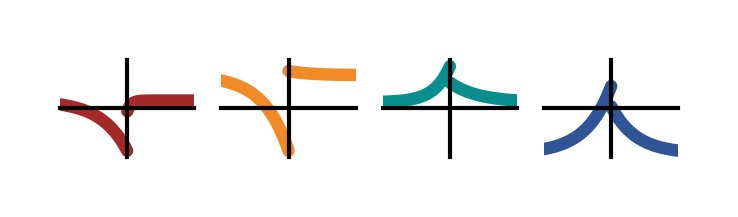

In [21]:
## Available rule quartets for this analysis
seed = 'c4e57a729e9023099fa81540a92d106e'
ind_seed = np.where(seq3['seed'] == seed)[0][0]
rule = data1[ind_seed]['theta']
aux.plot_4_rules(rule, linewidth=1.5, axwidth=0.5,figsize=(1.33,0.21))

# load spiketimes
sts = np.load("../data/data_sims/seq_IF_EEEIIEII_6pPol/rule_examples/" + seed + ".npy" , allow_pickle=True).item()

In [22]:
# compute the engram neurons for each stimulus, using the pretrain assessment
# pretrain assessment: presenting every possible stimlus (would-be familiar or novel) to the naive network, weights fixed.
n_recorded = 4096
l_stim_on_pretraineng = 1
l_stim_off_pretraineng = 1
l_pre_test_record = 1
frac_size_engram = 0.05
lpt = 30
lt = 50
n_fam_stim = 5
n_nov_stim = 2
n_tot_stim = 7
ontime_test = 0.2
offtime_test = 2.8
nseqs_test = 15
seq_length_test = 4
break_durations = [1, 9, 10, 40, 60, 180, 300, 600,  2400, 10800]
n_tests = len(break_durations)
bin_size_big = 0.1
l_pretraineng_tot = n_tot_stim*(l_stim_on_pretraineng+l_stim_off_pretraineng)
l_singlestims_test = n_tot_stim*(ontime_test + offtime_test)
l_seqstims_test = nseqs_test*(seq_length_test*ontime_test+offtime_test)
l_1test = l_singlestims_test + l_seqstims_test
test_starts = np.zeros(len(break_durations))
test_starts[0] = lpt + l_pretraineng_tot + lt + break_durations[0]
for i in range(1,len(break_durations)):
    test_starts[i] = test_starts[i-1] + break_durations[i] + l_1test
engram_neurons = aux.get_engram_neurons_npy(n_tot_stim, lpt, l_stim_on_pretraineng, l_stim_off_pretraineng, frac_size_engram, n_recorded, sts)
eng_rates = aux.get_eng_rate_npy(sts, test_starts, l_pre_test_record, l_1test, bin_size_big, n_tests, n_recorded, n_tot_stim, engram_neurons)

#make the ordering per engram. problem, some neurons can be assigned to 2 engrams, thouhg it is rare.
# assign a unique label to each neuron
neuron_label = np.zeros(n_recorded) + 7 #0->nov1, ... 6->fam5, 7 unassigned
for i in range(n_recorded):
    found = False
    eng_count = 0
    while (not found) and (eng_count <= 6):
        if len(np.argwhere(engram_neurons[eng_count, :] == i))>0:
            found = True
            neuron_label[i] = eng_count
        eng_count += 1

test_session 2


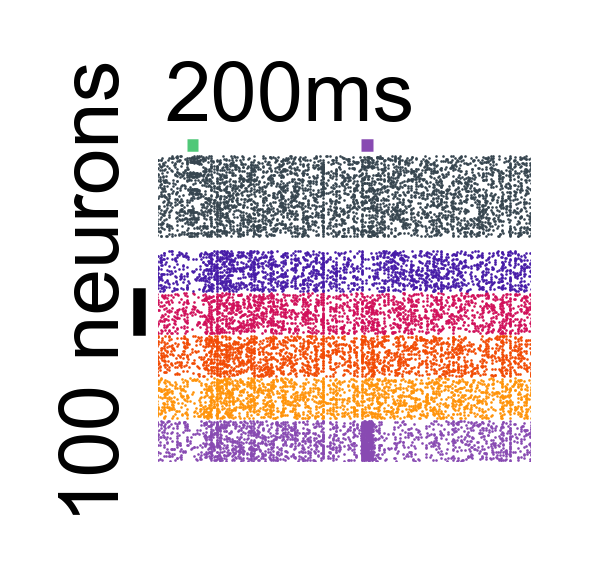

test_session 9


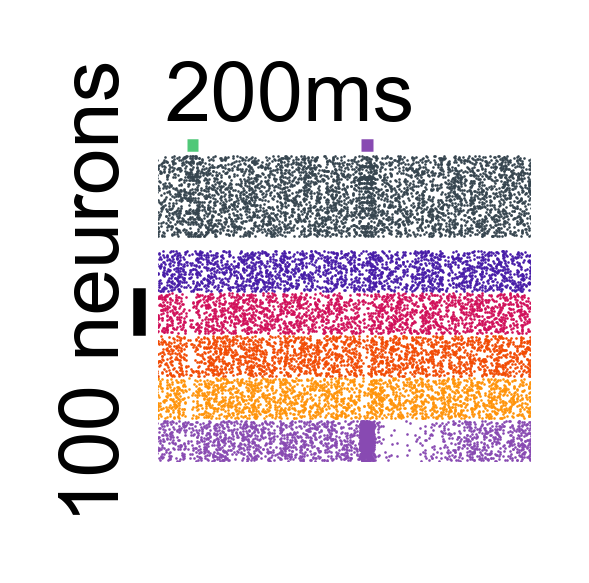

In [23]:
# raster plots by neurons, ordered by engram
test_sessions = [2, 9]
neuron_label_bis = np.array(neuron_label)
neuron_label_bis[np.where(neuron_label_bis==0)[0]] = -1
neuron_label_bis[np.where(neuron_label_bis==1)[0]] = -1
neuron_label_bis[np.where(neuron_label_bis==2)[0][100:]] = -1
neuron_label_bis[np.where(neuron_label_bis==2)[0][:100]] = 0

neuron_label_bis[np.where(neuron_label_bis==3)[0][100:]] = -1
neuron_label_bis[np.where(neuron_label_bis==3)[0][:100]] = 1

neuron_label_bis[np.where(neuron_label_bis==4)[0][100:]] = -1
neuron_label_bis[np.where(neuron_label_bis==4)[0][:100]] = 2

neuron_label_bis[np.where(neuron_label_bis==5)[0][100:]] = -1
neuron_label_bis[np.where(neuron_label_bis==5)[0][:100]] = 3

neuron_label_bis[np.where(neuron_label_bis==6)[0][100:]] = -1
neuron_label_bis[np.where(neuron_label_bis==6)[0][:100]] = 4

neuron_label_bis[np.where(neuron_label_bis==7)[0][200:]] = -1
neuron_label_bis[np.where(neuron_label_bis==7)[0][:200]] = 5
for test_session in test_sessions:
    print('test_session', test_session)
    aux.plot_raster_w_engrams_sep_background(sts=sts,
        neuron_labels=neuron_label_bis,
        n_recorded=n_recorded,
        colors_label = ['#36454F', aux.color_nov1, aux.color_fam1, aux.color_fam2, aux.color_fam3, aux.color_fam4, aux.color_fam5, '#36454F'],
        colors_raster = [aux.color_fam1, aux.color_fam2, aux.color_fam3, aux.color_fam4, aux.color_fam5, '#36454F'],
        x_lim = [test_starts[test_session]+2.5, test_starts[test_session]+8.9],
        markersize=0.1,
        lag_engr_bg = 30,
        t_start_each_stim = [i*(ontime_test + offtime_test) for i in range(7)] + test_starts[test_session],
        ontime = ontime_test,
        linewidth_stim_line=1.5,
        y_stim_line = 730,
        figsize= (0.8,0.7),
        x_label= "200ms",
        x_ticks= [],
        x_ticklabels= [],
        y_ticks=[],
        y_label="100 neurons",
        y_lim=[0,800],
        fontsize=10,
        dpi=600,
        ylabel_xloc=0.0,
        ylabel_yloc=0.0,
        xlabel_xloc=0.40,
        xlabel_yloc=0.92,
        y_bar_xloc=-0.05,
        y_bar_ylocs=[2.85/7, 3.6/7],
        axwidth=1.5);plt.show()


### Contextual novelty (Fig1.G)

In [24]:
# load the simulated data: 2500 rule quartets, 10 break times, 3 runs (trials)
seq3 = aux.load_and_merge("../data/data_sims/seq_IF_EEEIIEII_6pPol/",("2500_seq_1s4hBreaks_16112024_metrics.npy",))
seq_list = [seq3]

retrieved 2500/2500 simulations


In [25]:
# compute contextual novelty metrics
n_fam = 5
n_tot = 7
n_nov = 2
n_rules = seq1['eng_rate'].shape[0]
n_tests = seq1['eng_rate'].shape[1]
n_engs = seq1['eng_rate'].shape[2]
n_bins = seq1['eng_rate'].shape[3]
ontime_test = 2 #in number of bins. usually bin is 0.1s
offtime_test = 28 #in number of bins. usually bin is 0.1s
test_starts = 10 #in number of bins, how long do we record pretest (usually 1s)
t_breaks = [1, 9,  10, 40, 60,  180, 300, 600,  2400, 10800]

aux_big_array = np.array([aux.get_dr_stfam(n_bins=n_bins, test_starts=test_starts, ontime_test=ontime_test, offtime_test=offtime_test, rpop=seq['prate'],n_fam=n_fam,n_nov=n_nov) for seq in seq_list])
dr_famnov_list = aux_big_array[:,0,:,:]
dr_novnov_list = aux_big_array[:,1,:,:]

In [26]:
# ttests to check how many rules are responsive to the contextual novelty task
# here we have stimuli that are
# 1/ "famfam" familiar (seen in training), presented in the same order as in training
# 2/ "famnov" familiar (seen in training), presented in a different order than in training
# 3/ "novnov" novel (not seen in training), and thus presented in a different order than in training
inds_stim = aux.get_inds_last_el_sequence_stim_pres(n_bins, test_starts, ontime_test, offtime_test,n_fam,n_nov)
r_famfam =  np.array( [[np.mean(seq['prate'][:,:,inds_stim[i]], axis=2) for i in range(5)] for seq in seq_list ] )
r_famnov =  np.array( [[np.mean(seq['prate'][:,:,inds_stim[i]], axis=2) for i in range(5,10)] for seq in seq_list ] )
r_novnov =  np.array( [[np.mean(seq['prate'][:,:,inds_stim[i]], axis=2) for i in range(10,15)] for seq in seq_list ] )

n_ts = 10
proportion_famnov = np.zeros(n_ts)
proportion_novnov = np.zeros(n_ts)
pvalues_famnov =np.zeros((n_rules, n_ts))
pvalues_novnov =np.zeros((n_rules, n_ts))
for t in range(n_ts):
    for ind in range(n_rules):
        r_famfam_samples = r_famfam[:,:,ind,t].flatten()
        r_famnov_samples = r_famnov[:,:,ind,t].flatten()
        r_novnov_samples = r_novnov[:,:,ind,t].flatten()
        pvalues_famnov[ind,t] = ttest_ind(r_famnov_samples, r_famfam_samples).pvalue
        pvalues_novnov[ind,t] = ttest_ind(r_novnov_samples, r_famfam_samples).pvalue
    proportion_famnov[t] = np.sum(pvalues_famnov[:,t]<0.05)/len(pvalues_famnov)
    proportion_novnov[t] = np.sum(pvalues_novnov[:,t]<0.05)/len(pvalues_novnov)

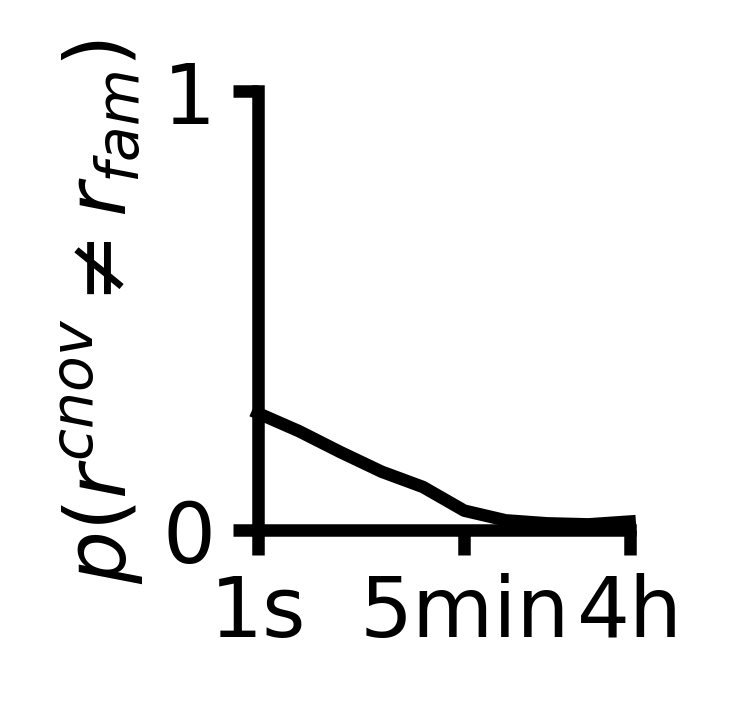

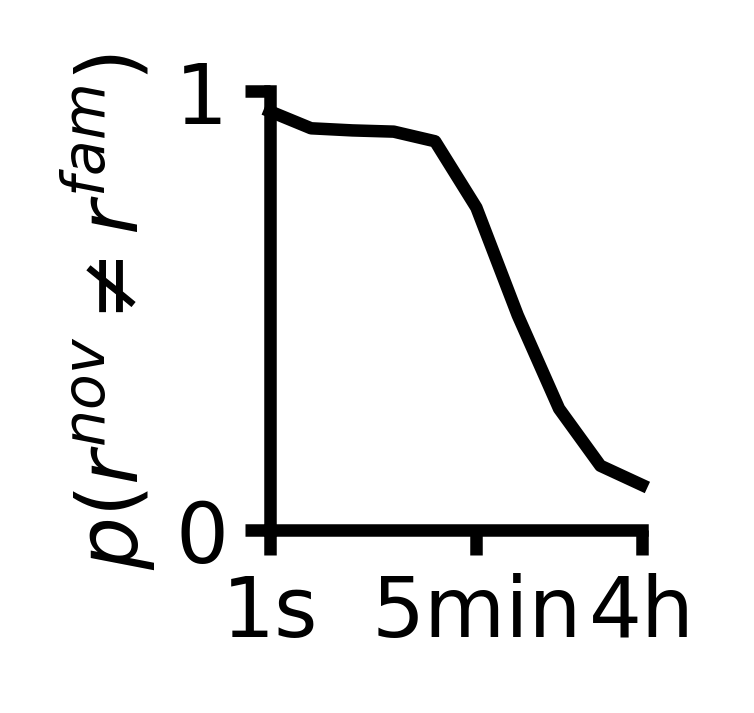

In [27]:
# compute the fraction of rule quartets responsive to contextual novelty for each break time
aux.plot_fraction_significant_rules(proportion_famnov,
                                    x_lim=[0,9],
                                    x_ticks=[0,5,9],
                                    x_ticklabels=['1s', '5min', '4h'],
                                    y_lim = [0,1],
                                    y_ticks=[0,1],
                                    x_label='',
                                    y_label=r'$p(r^{cnov} \neq r_{fam})$',
                                    xticks_pad=2,
                                    yticks_pad=2,
                                    labelpad_ylabel = 2,
                                    figsize=(0.8,0.95))

# compute the fraction of rule quartets responsive to full novelty for each break time (results should be similar to the familiarity detaction task)
aux.plot_fraction_significant_rules(proportion_novnov,
                                    x_lim=[0,9],
                                    x_ticks=[0,5,9],
                                    x_ticklabels=['1s', '5min', '4h'],
                                    y_lim = [0,1],
                                    y_ticks=[0,1],
                                    x_label='',
                                    y_label=r'$p(r^{nov} \neq r^{fam})$',
                                    xticks_pad=2,
                                    yticks_pad=2,
                                    labelpad_ylabel = 2,
                                    figsize=(0.8,0.95))


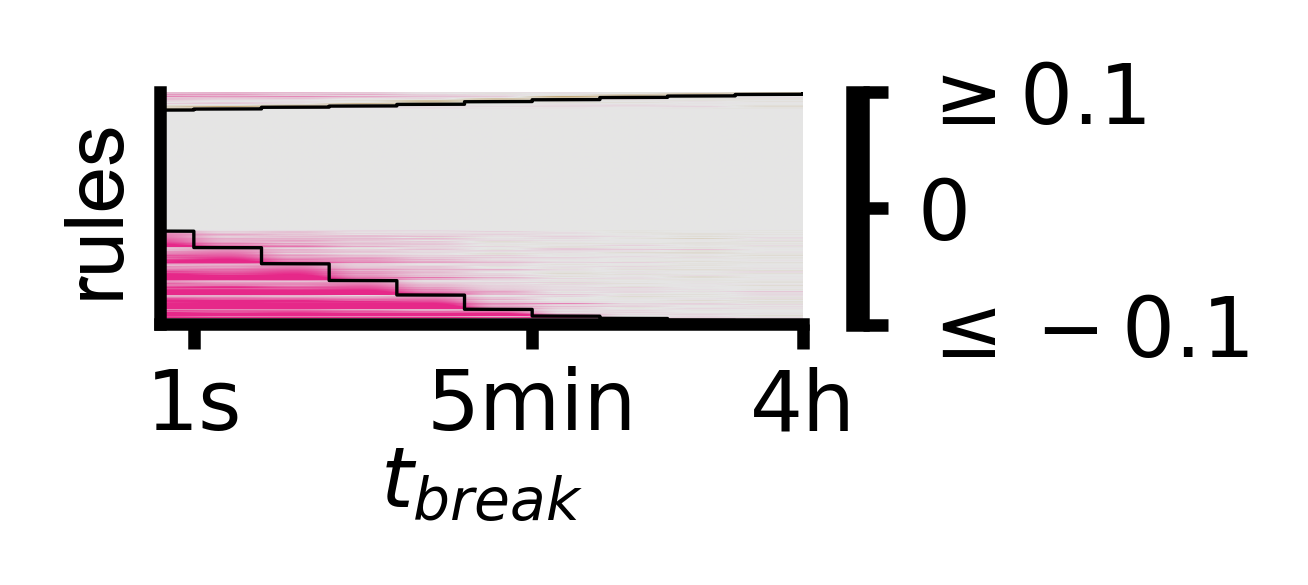

In [28]:
# major ordering 1: familiar or novel preferering
# major ordering 2: which t do you stop being significant at
# minor ordering: ascending mdr
sign_resp = pvalues_famnov < 0.05
# Find time of last singificant response
t_last_sign = np.zeros((n_rules))-1
for ind in range(n_rules):
    if len(np.where(sign_resp[ind,:]==True)[0]) > 0:
        t_last_sign[ind] = np.where(sign_resp[ind,:]==True)[0][-1]

dr_famnov = dr_famnov_list[0,:,:]
dr_famnov_reordered = np.zeros( (n_rules, n_ts) )
t_last_sign_reordered = np.zeros(n_rules)-1
count_left = 0
count_right = n_rules

for last_t in range(n_ts-1, -1, -1):
    ind_ts = np.where(t_last_sign == last_t)[0]
    ind_ts_fam = np.where(dr_famnov[:,last_t][ind_ts] < 0)[0]
    ind_ts_nov = np.where(dr_famnov[:,last_t][ind_ts] >= 0)[0]
    ordered_inds_fam = np.argsort(dr_famnov[:,last_t][ind_ts][ind_ts_fam])
    n_inds_fam_to_add = len(ordered_inds_fam)
    ordered_inds_nov = np.argsort(dr_famnov[:,last_t][ind_ts][ind_ts_nov])
    n_inds_nov_to_add = len(ordered_inds_nov)
    dr_famnov_reordered[count_left:(count_left+n_inds_fam_to_add)] = dr_famnov[ind_ts][ind_ts_fam][ordered_inds_fam]
    dr_famnov_reordered[(count_right-n_inds_nov_to_add):count_right] = dr_famnov[ind_ts][ind_ts_nov][ordered_inds_nov]
    t_last_sign_reordered[count_left:(count_left+n_inds_fam_to_add)] = last_t
    t_last_sign_reordered[(count_right-n_inds_nov_to_add):count_right] = last_t
    count_left += n_inds_fam_to_add
    count_right -= n_inds_nov_to_add

ts = [ np.sum(breaks[:i]) for i in range(1,len(breaks)+1) ]
aux.plot_metric_tbreaks_all_rules(dr_famnov_reordered,
    t_last_sign_reordered,
    figsize=(1.75, 0.6),#(1.75,1.15),
    dpi=600,
    cmap = aux.cmp_contnov,
    x_lim = [0,9.5],
    x_ticks = [0,5,9],
    x_ticklabels = ["1s","5min","4h"],
    x_label=r'$t_{break}$',
    y_lim=None,
    y_ticks=None,
    y_ticklabels=None,
    y_label="rules",
    vmin=-0.1,
    vmax=0.1,
    cbarticks=[-0.1,0,0.1],
    cbarticklabels=[r'$\leq-0.1$',r'$0$',r'$\geq 0.1$'],
    cbarhandlepad=-12,
    axwidth=1.5,
    linewidth=1.5,
    xticks_pad=2,
    yticks_pad=0,
    labelpad_xlabel=0,
    rotation=0,
    labelpad_ylabel=3,
    color_ylabel='black',
    heatmap_label=r'',
    linewidth_sign=0.4)

#### Plot specific rules

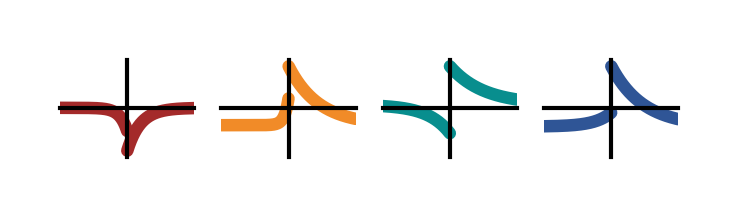

In [29]:
## Available rule quartets for this analysis
seed = '80e17fcc74d45e7b763d677e281b2914' #rule that keeps preferring novel, ON response to nov, aquired off response to fam
ind_seed = np.where(data1['seed'] == seed)[0][0]
rule = data1[ind_seed]['theta']
aux.plot_4_rules(rule, linewidth=1.5, axwidth=0.5,figsize=(1.33,0.21))

# load spiketimes
sts = np.load("../data/data_sims/seq_IF_EEEIIEII_6pPol/rule_examples/" + seed + ".npy" , allow_pickle=True).item()

In [30]:
# compute the engram neurons for each stimulus, using the pretrain assessment
# pretrain assessment: presenting every possible stimlus (would-be familiar or novel) to the naive network, weights fixed.
n_recorded = 4096
l_stim_on_pretraineng = 1
l_stim_off_pretraineng = 1
l_pre_test_record = 1
frac_size_engram = 0.05
lpt = 30
lt = 50
n_fam_stim = 5
n_nov_stim = 2
n_tot_stim = 7
ontime_test = 0.2
offtime_test = 2.8
nseqs_test = 15
seq_length_test = 4
break_durations = [1, 9, 10, 40, 60, 180, 300, 600,  2400, 10800]
n_tests = len(break_durations)
bin_size_big = 0.1
l_pretraineng_tot = n_tot_stim*(l_stim_on_pretraineng+l_stim_off_pretraineng)
l_singlestims_test = n_tot_stim*(ontime_test + offtime_test)
l_seqstims_test = nseqs_test*(seq_length_test*ontime_test+offtime_test)
l_1test = l_singlestims_test + l_seqstims_test
test_starts = np.zeros(len(break_durations))
test_starts[0] = lpt + l_pretraineng_tot + lt + break_durations[0]
for i in range(1,len(break_durations)):
    test_starts[i] = test_starts[i-1] + break_durations[i] + l_1test
engram_neurons = aux.get_engram_neurons_npy(n_tot_stim, lpt, l_stim_on_pretraineng, l_stim_off_pretraineng, frac_size_engram, n_recorded, sts)
eng_rates = aux.get_eng_rate_npy(sts, test_starts, l_pre_test_record, l_1test, bin_size_big, n_tests, n_recorded, n_tot_stim, engram_neurons)

#make the ordering per engram. problem, some neurons can be assigned to 2 engrams, thouhg it is rare.
# assign a unique label to each neuron
neuron_label = np.zeros(n_recorded) + 7 #0->nov1, ... 6->fam5, 7 unassigned
for i in range(n_recorded):
    found = False
    eng_count = 0
    while (not found) and (eng_count <= 6):
        if len(np.argwhere(engram_neurons[eng_count, :] == i))>0:
            found = True
            neuron_label[i] = eng_count
        eng_count += 1

test_session 2


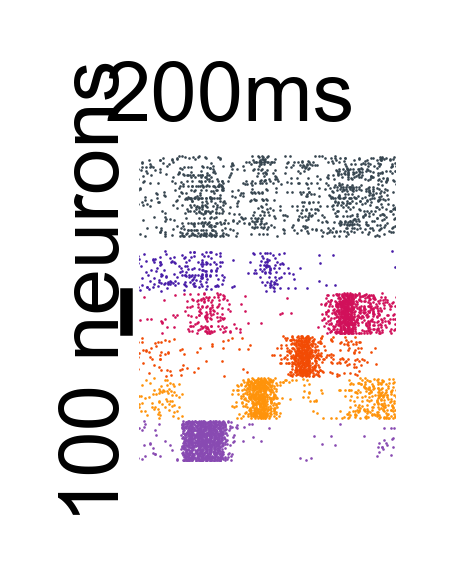

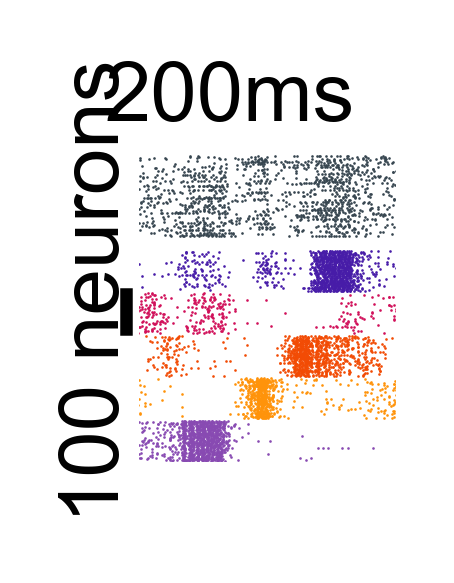

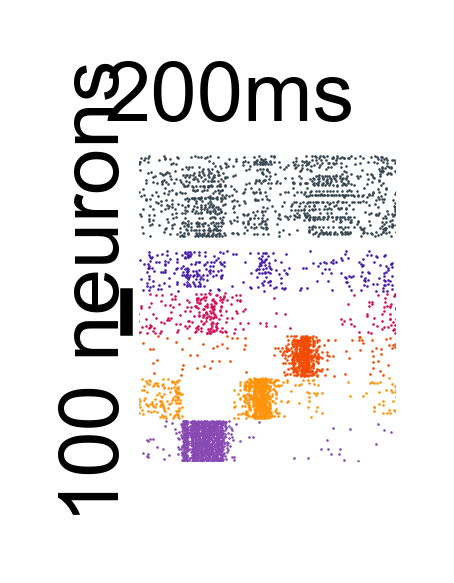

test_session 9


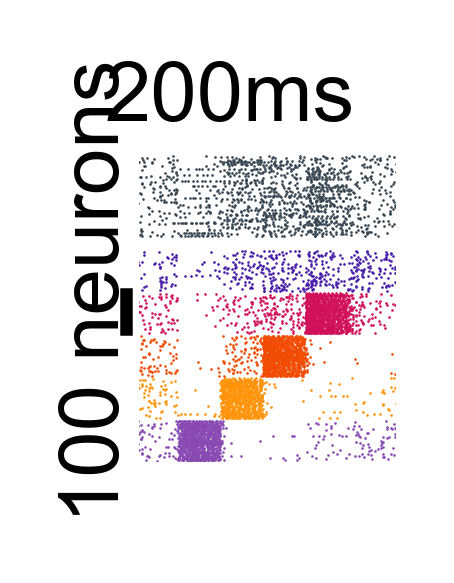

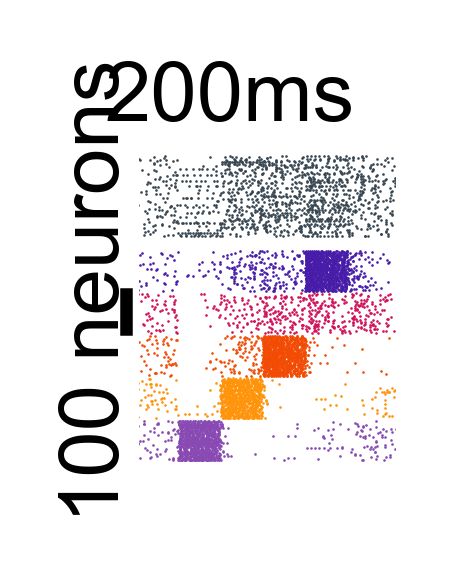

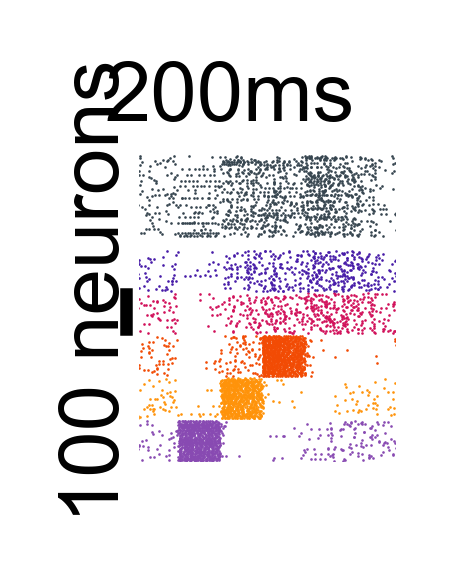

In [31]:
test_sessions = [2, 9]
neuron_label_bis = np.array(neuron_label)
neuron_label_bis[np.where(neuron_label_bis==0)[0]] = -1
neuron_label_bis[np.where(neuron_label_bis==1)[0]] = -1
neuron_label_bis[np.where(neuron_label_bis==2)[0][100:]] = -1
neuron_label_bis[np.where(neuron_label_bis==2)[0][:100]] = 0

neuron_label_bis[np.where(neuron_label_bis==3)[0][100:]] = -1
neuron_label_bis[np.where(neuron_label_bis==3)[0][:100]] = 1

neuron_label_bis[np.where(neuron_label_bis==4)[0][100:]] = -1
neuron_label_bis[np.where(neuron_label_bis==4)[0][:100]] = 2

neuron_label_bis[np.where(neuron_label_bis==5)[0][100:]] = -1
neuron_label_bis[np.where(neuron_label_bis==5)[0][:100]] = 3

neuron_label_bis[np.where(neuron_label_bis==6)[0][100:]] = -1
neuron_label_bis[np.where(neuron_label_bis==6)[0][:100]] = 4

neuron_label_bis[np.where(neuron_label_bis==7)[0][200:]] = -1
neuron_label_bis[np.where(neuron_label_bis==7)[0][:200]] = 5

for test_session in test_sessions:
    print('test_session', test_session)
    x_lims = [[test_starts[test_session]+20.8, test_starts[test_session]+22], [test_starts[test_session]+38.8, test_starts[test_session]+40], [test_starts[test_session]+56.8, test_starts[test_session]+58]]
    for x_lim in x_lims:
        aux.plot_raster_w_engrams_sep_background(sts=sts,
            neuron_labels=neuron_label_bis,
            n_recorded=n_recorded,
            colors_label = ['#36454F', aux.color_nov1, aux.color_fam1, aux.color_fam2, aux.color_fam3, aux.color_fam4, aux.color_fam5, '#36454F'],
            colors_raster = [aux.color_fam1, aux.color_fam2, aux.color_fam3, aux.color_fam4, aux.color_fam5, '#36454F'],
            x_lim = x_lim,
            markersize=0.1,
            lag_engr_bg = 30,
            t_start_each_stim = [i*(ontime_test + offtime_test) for i in range(7)] + test_starts[test_session],
            ontime = ontime_test,
            linewidth_stim_line=1.5,
            y_stim_line = 730,
            figsize= (0.55,0.7),
            x_label= "200ms",
            x_ticks= [],
            x_ticklabels= [],
            y_ticks=[],
            y_label="100 neurons",
            y_lim=[0,800],
            fontsize=10,
            dpi=600,
            ylabel_xloc=0.0,
            ylabel_yloc=0.0,
            xlabel_xloc=0.40,
            xlabel_yloc=0.92,
            y_bar_xloc=-0.05,
            y_bar_ylocs=[2.85/7, 3.6/7],
            axwidth=1.5);plt.show()

### Function rarity (Fig1.H)

1/ compute metrics for all functions in fig1  
2/ cutoff for a "functional" rule quartet on each task: here we use the "loose" criteria: "does this network respond to the task at any point"?

In [32]:
# novelty detection, familiarity detection and transient dynamics
save_dir = "../../../Data_Sims/BND_IF_EEEIIEII_6pPol/"

data1 = aux.load_and_merge(save_dir,("2500_1s4hBreaks_19082024_metrics.npy",))
data2 = aux.load_and_merge(save_dir,("2500_1s4hBreaks_20082024_metrics.npy",))
data3 = aux.load_and_merge(save_dir,("2500_1s4hBreaks_17092024_metrics.npy",))
data4 = aux.load_and_merge(save_dir,("2500_1s4hBreaks_22092024_metrics.npy",))
data5 = aux.load_and_merge(save_dir,("2500_1s4hBreaks_24092024_metrics.npy",))
dataset_list = [data1, data2, data3, data4, data5]

n_rules = len(data1)
dr = np.array([2*(d['r_nov'] - d['r_fam']) / (d['r_nov'] + d['r_fam']+0.01) for d in dataset_list])
dsr = np.array([2*(d['std_nov'] - d['std_fam']) / (d['std_nov'] + d['std_fam']+0.01) for d in dataset_list])
mdr = np.mean(dr, axis=0)
mdsr = np.mean(dsr, axis=0)
on_nov = np.max(data1['prate'][:,:,10:20], axis=2)/(np.nanmean(data1['prate'][:,:,10:20], axis=2)+0.01)

n_ts = 10
pvalues = np.zeros((n_rules, n_ts))
for t in range(n_ts):
    for ind in range(n_rules):
        r_nov_samples = np.array([d['r_nov'][ind,t] for d in dataset_list])
        r_fam_samples = np.array([d['r_fam'][ind,t] for d in dataset_list])
        pvalues[ind, t] = ttest_ind(r_nov_samples, r_fam_samples).pvalue
sign_resp_bnd = pvalues < 0.05

n_ts = 10
pvalues_trampl = np.zeros((n_rules, n_ts))
for t in range(n_ts):
    for ind in range(n_rules):
        on_nov_samples = np.array([np.max(d['prate'][ind,t,10:20], axis=0)/(np.nanmean(d['prate'][ind,t,10:20], axis=0)+0.01) for d in dataset_list])
        on_fam_samples = np.array([np.max(d['prate'][ind,t,50:60], axis=0)/(np.nanmean(d['prate'][ind,t,50:60], axis=0)+0.01) for d in dataset_list])
        pvalues_trampl[ind, t] = ttest_ind(on_nov_samples, on_fam_samples).pvalue
sign_resp_trampl = pvalues_trampl < 0.05

retrieved 2500/2500 simulations
retrieved 2500/2500 simulations
retrieved 2500/2500 simulations
retrieved 2500/2500 simulations
retrieved 2500/2500 simulations


/var/folders/fg/6y_rzvdn0_s9tr1lxxw5r9p40000gn/T/ipykernel_23262/2385990468.py:16: RuntimeWarning: Mean of empty slice
  on_nov = np.max(data1['prate'][:,:,10:20], axis=2)/(np.nanmean(data1['prate'][:,:,10:20], axis=2)+0.01)
/var/folders/fg/6y_rzvdn0_s9tr1lxxw5r9p40000gn/T/ipykernel_23262/2385990468.py:31: RuntimeWarning: Mean of empty slice
  on_nov_samples = np.array([np.max(d['prate'][ind,t,10:20], axis=0)/(np.nanmean(d['prate'][ind,t,10:20], axis=0)+0.01) for d in dataset_list])
/var/folders/fg/6y_rzvdn0_s9tr1lxxw5r9p40000gn/T/ipykernel_23262/2385990468.py:32: RuntimeWarning: Mean of empty slice
  on_fam_samples = np.array([np.max(d['prate'][ind,t,50:60], axis=0)/(np.nanmean(d['prate'][ind,t,50:60], axis=0)+0.01) for d in dataset_list])


In [33]:
# successor representation + contextual novelty
seq3 = aux.load_and_merge("../../../Data_Sims/seq_IF_EEEIIEII_6pPol/",("2500_seq_1s4hBreaks_16112024_metrics.npy",))
seq_list = [seq3]

break_durations = [1, 9, 10, 40, 60, 180, 300, 600, 2400, 10800]
total_breaks = [np.sum(break_durations[:i+1]) for i in range(len(break_durations))]
n_fam = 5
n_tot = 7
n_nov = 2
n_rules = seq3['eng_rate'].shape[0]
n_tests = seq3['eng_rate'].shape[1]
n_engs = seq3['eng_rate'].shape[2]
n_bins = seq3['eng_rate'].shape[3]
ontime_test = 2 #in number of bins. usually bin is 0.1s
offtime_test = 28 #in number of bins. usually bin is 0.1s
test_starts = 10 #in number of bins, how long do we record pretest (usually 1s)
t_breaks = [1, 9,  10, 40, 60,  180, 300, 600,  2400, 10800]

# contextual novelty
inds_stim = aux.get_inds_last_el_sequence_stim_pres(n_bins, test_starts, ontime_test, offtime_test,n_fam,n_nov)
r_famfam =  np.array( [[np.mean(seq['prate'][:,:,inds_stim[i]], axis=2) for i in range(5)] for seq in seq_list ] )
r_famnov =  np.array( [[np.mean(seq['prate'][:,:,inds_stim[i]], axis=2) for i in range(5,10)] for seq in seq_list ] )
n_ts = 10
pvalues_famnov =np.zeros((n_rules, n_ts))
for t in range(n_ts):
    for ind in range(n_rules):
        r_famfam_samples = r_famfam[:,:,ind,t].flatten()
        r_famnov_samples = r_famnov[:,:,ind,t].flatten()
        pvalues_famnov[ind,t] = ttest_ind(r_famnov_samples, r_famfam_samples).pvalue
sign_resp_cont_nov = pvalues_famnov < 0.05

aux_big_array = np.nan_to_num(aux.get_dr_stfam(n_bins=n_bins, test_starts=test_starts, ontime_test=ontime_test, offtime_test=offtime_test, rpop=seq3['prate'],n_fam=n_fam,n_nov=n_nov), nan=0)
dr_famnov = aux_big_array[0,:,:]

# successor representation
fams_novs_ttest = [aux.get_rsucc_rnov(eng_rate=seq['eng_rate'], n_tot=n_tot, n_bins=n_bins, test_starts=test_starts, ontime_test=ontime_test, offtime_test=offtime_test,
                 n_rules=n_rules, n_tests=n_tests, n_fam=n_fam, n_engs=n_engs) for seq in seq_list]

metric_num = 3 #3 = m+1
pvalues_succ =np.zeros((n_rules, n_ts))
for test_num in range(n_ts):
    for rule_num in range(n_rules):
        fam_samples = np.array( [ fams_novs_ttest[i][0][rule_num,test_num,metric_num,:] for i in range(len(seq_list)) ] ).flatten()
        nov_samples = np.array( [ fams_novs_ttest[i][1][rule_num,test_num,:,:] for i in range(len(seq_list)) ] ).flatten()
        pvalues_succ[rule_num, test_num] = ttest_ind(nov_samples, fam_samples).pvalue
sign_resp_succ = pvalues_succ < 0.05

retrieved 2500/2500 simulations


In [34]:
# number of rules with different functions, generous definitions when applicable
inds_nov = np.unique(np.where( aux.N_OR( [aux.N_AND([sign_resp_bnd[:,t], mdr[:, t]>0]) for t in range(10)] ))[0])
n_nov = len(inds_nov)
print('n_nov', n_nov, n_nov/2500)

inds_fam = np.unique(np.where( aux.N_OR( [aux.N_AND([sign_resp_bnd[:,t], mdr[:, t]<0]) for t in range(10)] ))[0])
n_fam = len(inds_fam)
print('n_fam', n_fam, n_fam/2500)

inds_trampl = np.unique(np.where( aux.N_OR( [sign_resp_trampl[:,t] for t in range(10)] ))[0])
n_on = len(inds_trampl)
print('n_on', n_on, n_on/2500)

inds_cont_nov = np.unique(np.where( aux.N_OR( [sign_resp_cont_nov[:,t] for t in range(10)] ))[0])
n_cont_nov = len(inds_cont_nov)
print('n_cont_nov', n_cont_nov, n_cont_nov/2500)

inds_succ = np.unique(np.where( aux.N_OR( [sign_resp_succ[:,t] for t in range(10)] ))[0])
n_succ = len(inds_succ)
print('n_succ', n_succ, n_succ/2500)

n_functions_per_rule = np.zeros(n_rules)
for i in range(n_rules):
    n_functions_per_rule[i] = (i in inds_nov) + (i in inds_fam) + (i in inds_trampl) + (i in inds_cont_nov) + (i in inds_succ)

n_0_function = len(np.where(n_functions_per_rule==0)[0])
n_1_function = len(np.where(n_functions_per_rule==1)[0])
n_2_function = len(np.where(n_functions_per_rule==2)[0])
n_3_function = len(np.where(n_functions_per_rule==3)[0])
n_4_function = len(np.where(n_functions_per_rule>=4)[0])

print(n_0_function, n_1_function, n_2_function, n_3_function, n_4_function, n_0_function+n_1_function+n_2_function+n_3_function+n_4_function)

n_nov 2451 0.9804
n_fam 435 0.174
n_on 2207 0.8828
n_cont_nov 1196 0.4784
n_succ 2488 0.9952
1 13 174 1025 1287 2500


In [35]:
print(np.sum(sign_resp_bnd[:,1])/2500, "rules respond after 10s on the novelty/familiarity task (T-test p,0.05)")
print(np.sum(sign_resp_bnd[:,-1])/2500, "rules respond after 4h on the novelty/familiarity task (T-test p,0.05)")
print(np.sum(sign_resp_trampl[:,1])/2500, "rules respond after 10s on the novelty/familiarity task w transient dynamics (T-test p,0.05)")
print(np.sum(sign_resp_trampl[:,-1])/2500, "rules respond after 4h on the novelty/familiarity task w transient dynamics (T-test p,0.05)")
print(np.sum(sign_resp_succ[:,1])/2500, "rules respond after 10s on the succ task (T-test p,0.05)")
print(np.sum(sign_resp_succ[:,-1])/2500, "rules respond after 4h on the succ task (T-test p,0.05)")
print(np.sum(sign_resp_cont_nov[:,1])/2500, "rules respond after 10s on the contextual novelty task (T-test p,0.05)")
print(np.sum(sign_resp_cont_nov[:,-1])/2500, "rules respond after 4h on the contextual novelty task (T-test p,0.05)")

0.936 rules respond after 10s on the novelty/familiarity task (T-test p,0.05)
0.0688 rules respond after 4h on the novelty/familiarity task (T-test p,0.05)
0.5696 rules respond after 10s on the novelty/familiarity task w transient dynamics (T-test p,0.05)
0.0564 rules respond after 4h on the novelty/familiarity task w transient dynamics (T-test p,0.05)
0.9824 rules respond after 10s on the succ task (T-test p,0.05)
0.0284 rules respond after 4h on the succ task (T-test p,0.05)
0.226 rules respond after 10s on the contextual novelty task (T-test p,0.05)
0.02 rules respond after 4h on the contextual novelty task (T-test p,0.05)


/var/folders/fg/6y_rzvdn0_s9tr1lxxw5r9p40000gn/T/ipykernel_23262/1041613299.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=25, ha='right', font='arial', fontsize=fontsize)


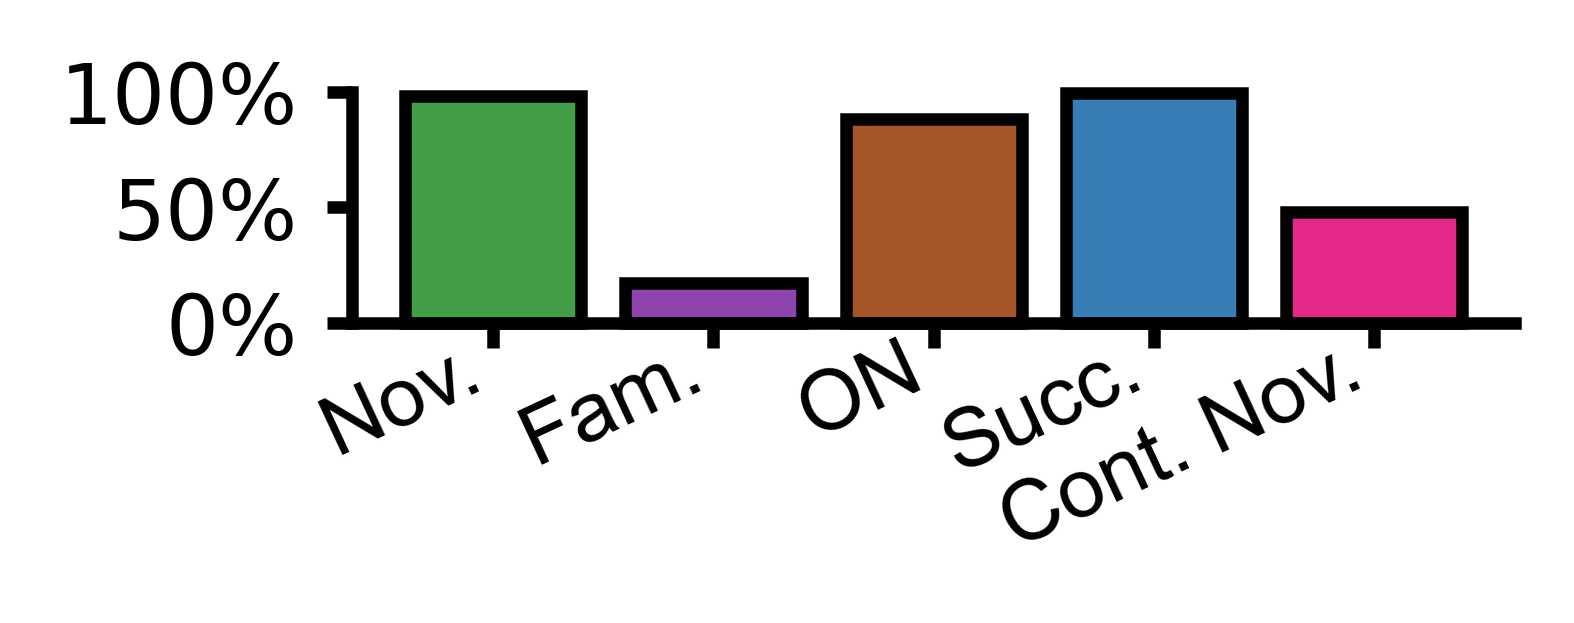

In [36]:
figsize = (2.5, 0.5)
dpi=600
fontsize=10
axwidth=1.5
# Define the total number of rules
total_rules = len(sign_resp_bnd)

# Define the counts for each function
n_nov_fraction = n_nov / total_rules
n_fam_fraction = n_fam / total_rules
n_on_fraction = n_on / total_rules
n_succ_fraction = n_succ / total_rules
n_cont_nov_fraction = n_cont_nov / total_rules

# Define labels and fractions
labels = ['Nov.', 'Fam.', 'ON', 'Succ.', 'Cont. Nov.']
fractions = [n_nov_fraction, n_fam_fraction, n_on_fraction,  n_succ_fraction, n_cont_nov_fraction]

color_trampl = (166/256, 86/256, 40/256)
color_fam = (142/256,68/256,173/256)
color_nov= (67/256,160/256, 71/256)
color_stfam = (231/256, 41/256, 138/256)
color_succ = (55/256, 126/256, 184/256)

fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
ax.bar(labels, fractions, color=[color_nov, color_fam, color_trampl, (55/256, 126/256, 184/256), color_stfam], 
       edgecolor='black', linewidth=axwidth, clip_on =False)
ax.set_ylim(0, 1)  # Adjust the limits to fit the data
ax.set_yticks([0, 0.5, 1])
ax.set_yticklabels(['0%', '50%', '100%'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(axwidth)
ax.spines['left'].set_linewidth(axwidth)
ax.tick_params(axis='x', pad=-2)
ax.set_xticklabels(labels, rotation=25, ha='right', font='arial', fontsize=fontsize)

ax.tick_params(axis='x', width=axwidth, labelsize=fontsize, length=2*axwidth)
ax.tick_params(axis='y', width=axwidth, labelsize=fontsize, length=2*axwidth)

plt.show()

1 13 174 1025 1287 2500


/var/folders/fg/6y_rzvdn0_s9tr1lxxw5r9p40000gn/T/ipykernel_23262/1792147451.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=0, font='arial', fontsize=fontsize)


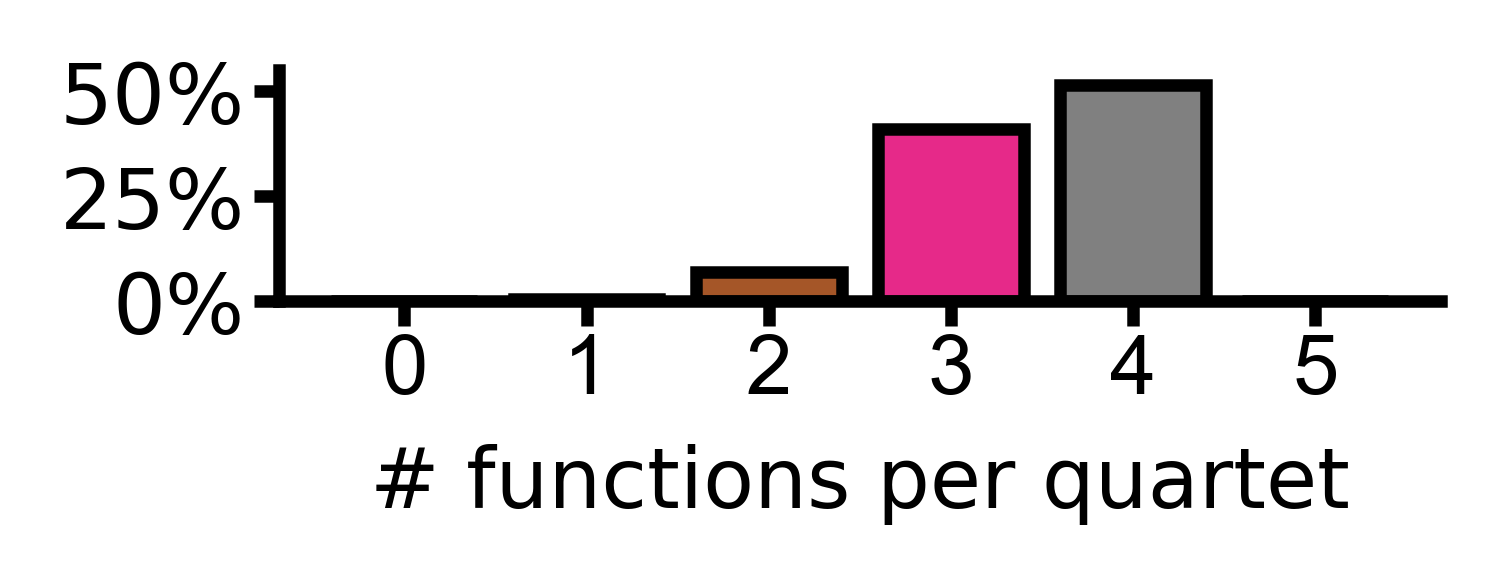

In [37]:
figsize = (2.5, 0.5)
dpi=600
fontsize=10
axwidth=1.5

# Define the counts for each function

n_0_function_fraction = n_0_function/n_rules
n_1_function_fraction = n_1_function/n_rules
n_2_function_fraction = n_2_function/n_rules
n_3_function_fraction = n_3_function/n_rules
n_4_function_fraction = n_4_function/n_rules
print(n_0_function, n_1_function, n_2_function, n_3_function, n_4_function, n_0_function+n_1_function+n_2_function+n_3_function+n_4_function)

# Define labels and fractions
labels = ['0', '1', '2', '3', '4', '5']
fractions = [n_0_function_fraction, n_1_function_fraction, n_2_function_fraction,
             n_3_function_fraction, n_4_function_fraction, 0]

color_trampl = (166/256, 86/256, 40/256)
color_fam = (142/256,68/256,173/256)
color_nov= (67/256,160/256, 71/256)
color_stfam = (231/256, 41/256, 138/256)

# Create the bar plot with a logarithmic y-axis
fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
ax.bar(labels, fractions, color=[color_nov, color_fam, color_trampl, color_stfam, 'grey'], 
       edgecolor='black', linewidth=axwidth)
ax.set_ylim(0, 0.55)  # Adjust the limits to fit the data
ax.set_yticks([0, 0.25, 0.5])
ax.set_yticklabels(['0%', '25%', '50%'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(axwidth)
ax.spines['left'].set_linewidth(axwidth)
ax.tick_params(axis='x', pad=1)
ax.tick_params(axis='y', pad=1)
ax.set_xticklabels(labels, rotation=0, font='arial', fontsize=fontsize)
ax.set_xlabel('# functions per quartet')

ax.tick_params(axis='x', width=axwidth, labelsize=fontsize, length=2*axwidth)
ax.tick_params(axis='y', width=axwidth, labelsize=fontsize, length=2*axwidth)

plt.show()